In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sshikamaru/car-object-detection")
print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/car-object-detection


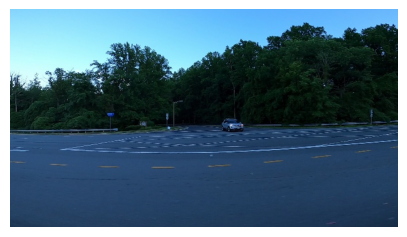

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
# Display first image
image = Image.open(path + "/data/training_images/vid_4_980.jpg")
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()


In [3]:
import pandas as pd
df = pd.read_csv(path + "/data/train_solution_bounding_boxes (1).csv")
# image = name, xmin = bounding box xmin coord, ymin = bounding box ymin coord,
# xmax = bounding box xmax coord, ymax = bounding box ymax coord
df.head()


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
!pip install cv2

In [ ]:
!pip install opencv-python-headless

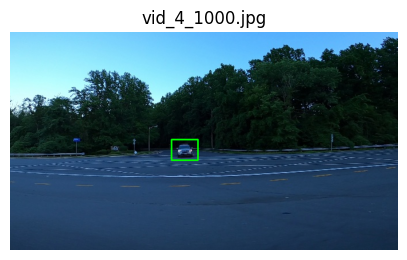

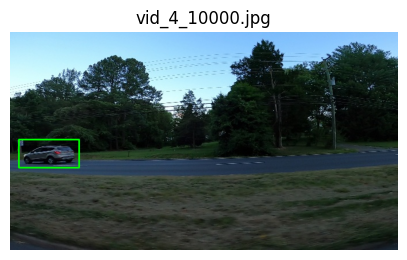

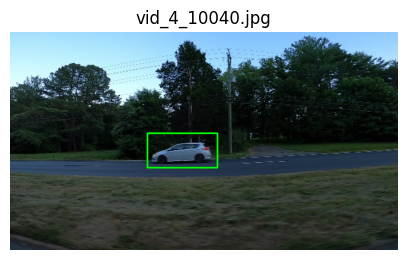

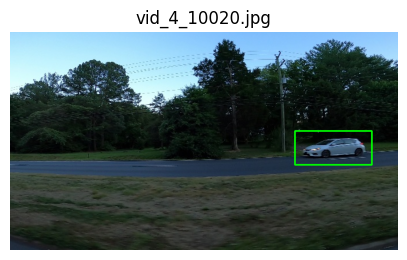

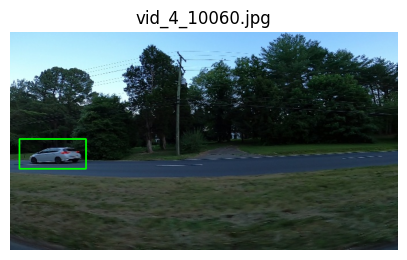

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os


# Preview first 5 images with bounding boxes
for i in range(5):
    row = df.iloc[i]

    # Get values
    name = row["image"]
    xmin, ymin, xmax, ymax = map(int, [row["xmin"], row["ymin"], row["xmax"], row["ymax"]])

    # Construct image path
    image_path = os.path.join("/kaggle/input/car-object-detection/data/training_images/", name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not load image at {image_path}")
        continue

    # Draw bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display
    plt.figure(figsize=(5, 5))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(name)
    plt.show()


In [7]:
# make directories for YOLO data structure
import os
# make new directory to store data because kaggle dataset is read-only
os.makedirs("/kaggle/working/dataset", exist_ok=True)
for ext_dir in ["images", "labels"]:
  for int_dir in ["train", "val", "test"]:
    # os.path.join combines the file paths safely
    # exist_ok allows the path to be made even if it already exists
    os.makedirs(os.path.join("/kaggle/working/dataset", ext_dir, int_dir), exist_ok=True)

In [8]:
import shutil
def get_annotation(df, folder):
  for idx, row in df.iterrows():
    # extract name, xmin, ymin, xmax, ymax from each image with a bounding box
    name = row["image"]
    xmin = row["xmin"]
    ymin = row["ymin"]
    xmax = row["xmax"]
    ymax = row["ymax"]

    width = xmax - xmin
    height = ymax - ymin
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2

    with Image.open(os.path.join("/kaggle/input/car-object-detection/data/training_images", name)) as img:
      img_width, img_height = img.size

    width /= img_width
    height /= img_height
    center_x /= img_width
    center_y /= img_height

    shutil.copy(os.path.join("/kaggle/input/car-object-detection/data/training_images", name),
                os.path.join("/kaggle/working/dataset/images", folder, name))

    filepath = os.path.join("/kaggle/working/dataset/labels", folder, os.path.splitext(name)[0] + ".txt")
    with open(filepath, "w") as f:
      f.write(f"{0} {center_x} {center_y} {width} {height}")


In [9]:
from sklearn.model_selection import train_test_split
# split randomized dataset into training and validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# perform annotation on both datasets
get_annotation(train_df, "train")
get_annotation(val_df, "val")


In [10]:
# copy test images to working dataset to be evaluated by model
# after training
test_imgs = os.listdir("/kaggle/input/car-object-detection/data/testing_images")
for img in test_imgs:
  shutil.copy("/kaggle/input/car-object-detection/data/testing_images/" + img, "/kaggle/working/dataset/images/test/" + img)

In [11]:
# create yaml file to be passed to YOLO model
data = f"""
path: /kaggle/working/dataset

# training images
train: ../images/train

# validation images
val: ../images/val

# test images
test: ../images/test

# number of classes
nc: 1

# names of classes
names: ["car"]
"""

# create data.yaml file in working dataset and write to it
with open("data.yaml", "w") as f:
  f.write(data)


In [ ]:
%pip install ultralytics

In [13]:
from ultralytics import YOLO
# load yolov11 pre-trained model
model = YOLO("yolo11n.pt")

# train the model on the data
train_results = model.train(data="data.yaml",
                            epochs=50,
                            imgsz=650,
                            batch=16,
                            name="car_detection_model",
                            device="cpu"
                            )

      48/50         0G     0.9287     0.6923     0.9771          3        672: 100%|██████████| 20/20 [01:08<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

                   all         94         94      0.513      0.745       0.65       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.9275     0.6851     0.9777          3        672: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

                   all         94         94      0.491      0.777      0.648       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.9418     0.6568     0.9713          3        672: 100%|██████████| 20/20 [01:10<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

                   all         94         94       0.51      0.775      0.652      0.421



50 epochs completed in 1.035 hours.
Optimizer stripped from runs/detect/car_detection_model/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/car_detection_model/weights/best.pt, 5.5MB

Validating runs/detect/car_detection_model/weights/best.pt...
Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


                   all         94         94      0.493      0.872      0.735      0.476
Speed: 0.3ms preprocess, 32.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/car_detection_model


In [23]:
results = train_results.results_dict

# Print relevant metrics
print(f"Metrics for the trained model:")
print(f" Precision: {results['metrics/precision(B)']}")
print(f" Recall: {results['metrics/recall(B)']}")
print(f" mAP@0.5: {results['metrics/mAP50(B)']}")
print(f" mAP@0.5:0.95: {results['metrics/mAP50-95(B)']}")

Metrics for the trained model:
 Precision: 0.4929649941745347
 Recall: 0.8723404255319149
 mAP@0.5: 0.7349222357356002
 mAP@0.5:0.95: 0.47569905475624263



image 1/1 /kaggle/working/dataset/images/test/vid_5_420.jpg: 384x672 1 car, 51.6ms
Speed: 2.3ms preprocess, 51.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 672)
Annotation file not found for /kaggle/working/dataset/images/test/vid_5_420.jpg


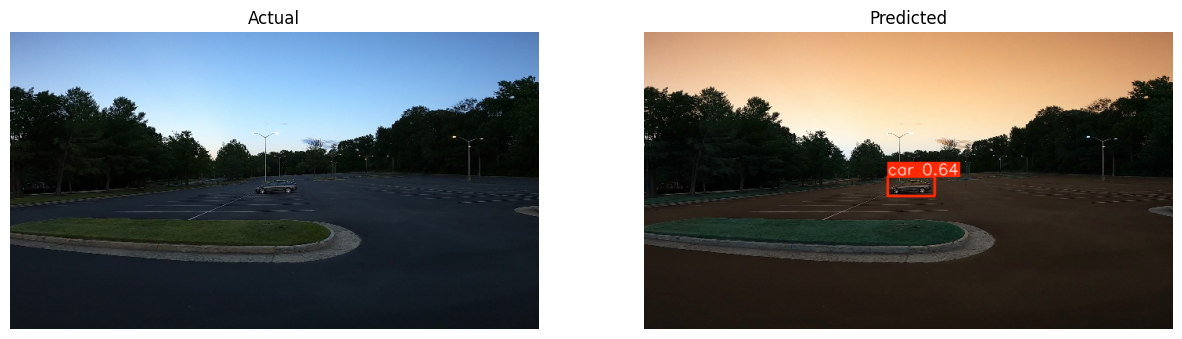


image 1/1 /kaggle/working/dataset/images/test/vid_5_29560.jpg: 384x672 1 car, 62.4ms
Speed: 3.7ms preprocess, 62.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 672)
Annotation file not found for /kaggle/working/dataset/images/test/vid_5_29560.jpg


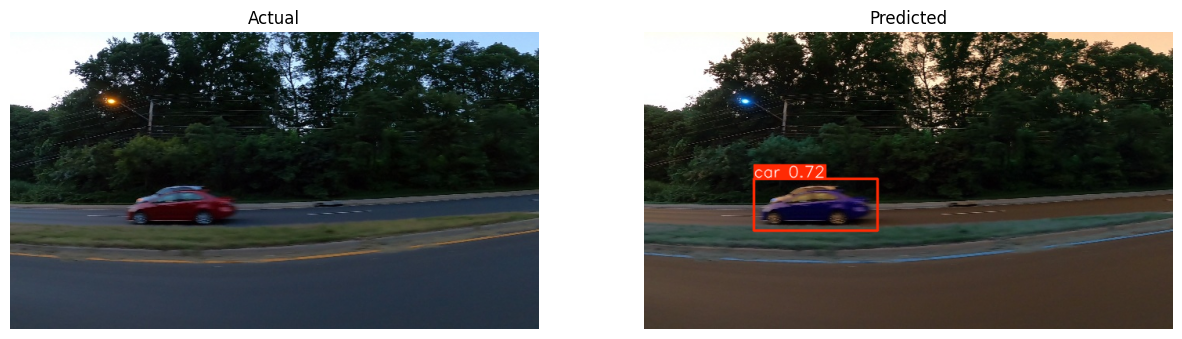


image 1/1 /kaggle/working/dataset/images/test/vid_5_27840.jpg: 384x672 1 car, 70.0ms
Speed: 2.3ms preprocess, 70.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 672)
Annotation file not found for /kaggle/working/dataset/images/test/vid_5_27840.jpg


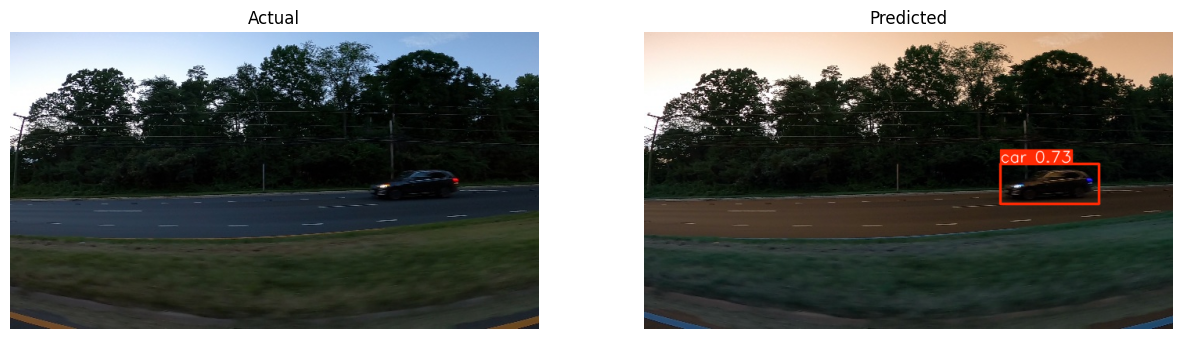


image 1/1 /kaggle/working/dataset/images/test/vid_5_28360.jpg: 384x672 (no detections), 104.5ms
Speed: 2.3ms preprocess, 104.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 672)
Annotation file not found for /kaggle/working/dataset/images/test/vid_5_28360.jpg


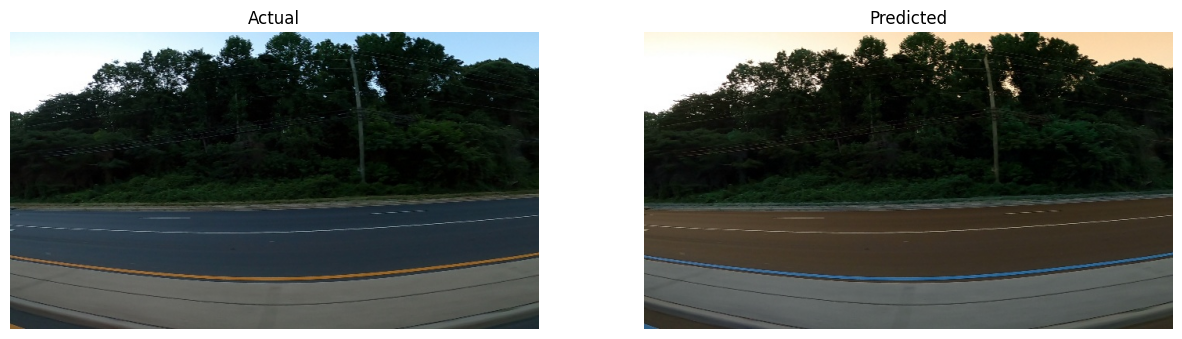


image 1/1 /kaggle/working/dataset/images/test/vid_5_29640.jpg: 384x672 (no detections), 51.7ms
Speed: 2.2ms preprocess, 51.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 672)
Annotation file not found for /kaggle/working/dataset/images/test/vid_5_29640.jpg


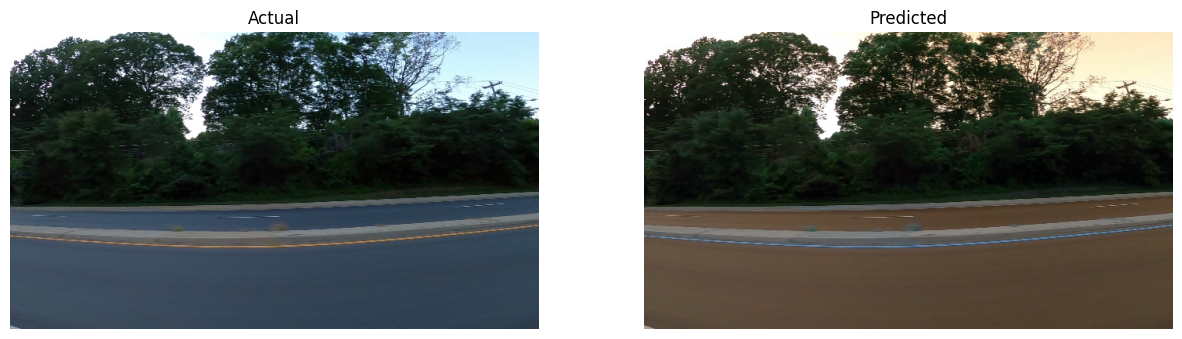

In [21]:
# prompt: plot 5 annotated images both predicted and actual results of test data side by side

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

# Assuming 'model' is your trained YOLO model and 'test_imgs' is a list of test image paths
# Replace with your actual model and image paths

def plot_predictions(model, test_imgs, num_images=5):
    for i in range(min(num_images, len(test_imgs))):
        image_path = test_imgs[i]
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = model(image_path)  # Predict on the image

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Plot the original image with actual annotations (replace with your actual annotation loading)
        # Example (assuming annotations are stored in a text file for each image):
        try:
            annotation_file = os.path.splitext(image_path)[0] + '.txt'
            with open(annotation_file, 'r') as f:
              for line in f:
                  class_id, x_center, y_center, width, height = map(float, line.split())
                  img_width, img_height = img.shape[1], img.shape[0]
                  x_min = int((x_center - width / 2) * img_width)
                  y_min = int((y_center - height / 2) * img_height)
                  x_max = int((x_center + width / 2) * img_width)
                  y_max = int((y_center + height / 2) * img_height)
                  cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        except FileNotFoundError:
          print(f"Annotation file not found for {image_path}")
        axes[0].imshow(img_rgb)
        axes[0].set_title("Actual")
        axes[0].axis("off")

        #Plot the predicted bounding boxes
        annotated_frame = results[0].plot()
        axes[1].imshow(annotated_frame)
        axes[1].set_title("Predicted")
        axes[1].axis("off")

        plt.show()
# Example Usage
test_image_dir = "/kaggle/working/dataset/images/test" # Replace with the correct path
test_imgs = [os.path.join(test_image_dir, img) for img in os.listdir(test_image_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]

plot_predictions(model, test_imgs)
